In [1]:
# 101 revised version
# change the range of simulation (more accurate to horizontal well)
# Change the injection idx, at the center of the well.

In [2]:
# %cd ~/projects/mariner

/home/shenyaojin/projects/mariner


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
# Load necessary data: gauge and geometry
from fiberis.simulator.core import pds
from fiberis.analyzer.Data1D import Data1D_Gauge
from fiberis.analyzer.Geometry3D import DataG3D_md

In [4]:
# Define the datapath
gauge_data = "data/new/s_well/gauge_data"
from glob import glob
gauge_files = glob(gauge_data + "/*.npz")
# Gauge md
gauge_md_data = "data/new/s_well/geometry/gauge_md_swell.npz"
# Frac Hit md
frac_hit_md = glob("data/new/s_well/geometry/frac_hit/*.npz")
# sort the file
frac_hit_md = sorted(frac_hit_md)

In [5]:
# Load and extract the data
gauge_md_dataframe = DataG3D_md.G3DMeasuredDepth()
gauge_md_dataframe.load_npz(gauge_md_data)
gauge_md = gauge_md_dataframe.data
# Load the gauge data
gauge_data_all = []
from tqdm import tqdm
start_time = datetime.datetime(2020, 4, 1)
end_time = datetime.datetime(2021, 1, 1)
for file in tqdm(gauge_files):
    gauge_data_dataframe = Data1D_Gauge.Data1DGauge()
    gauge_data_dataframe.load_npz(file)
    # Crop the data
    gauge_data_dataframe.crop(start_time, end_time)
    gauge_data_all.append(gauge_data_dataframe)

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 154.91it/s]


In [6]:
# Do the simulation
simulator = pds.PDS1D_MultiSource()

In [7]:
from fiberis.analyzer.Data2D import Data2D_XT_DSS
DASdata = Data2D_XT_DSS.DSS2D()
DASdata.load_npz("data/new/s_well/DASdata/LFDASdata_stg1_interval_swell.npz")

In [8]:
# Set up the grid. 6000 ft with Neumann BC; finer grid at frac hit location
mesh = np.linspace(DASdata.daxis[-1] -5500, DASdata.daxis[-1], 5500)
# Combine the frac hit location
frac_hit = []
for file in tqdm(frac_hit_md):
    frac_hit_dataframe = DataG3D_md.G3DMeasuredDepth()
    frac_hit_dataframe.load_npz(file)
    frac_hit.append(frac_hit_dataframe.data)

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2581.59it/s]


In [9]:
# Convert frac hit to 1D array
frac_hit_sep = frac_hit.copy()
frac_hit = np.concatenate(frac_hit)
mesh = np.linspace(DASdata.daxis[-1] -4900, DASdata.daxis[-1], 4900)
# refine the mesh
from fiberis.utils import mesh_utils

for frac_hit_iter in frac_hit:
    mesh = mesh_utils.refine_mesh(mesh, [frac_hit_iter - 1, frac_hit_iter + 1], 10)
nx = len(mesh)

In [10]:
simulator.set_mesh(mesh)
simulator.set_bcs('Neumann', 'Neumann')
simulator.set_t0(0)
simulator.set_initial(np.ones_like(mesh) * gauge_data_all[5].data[0]) # Gauge 6 and gauge 7; stage 7 and 8

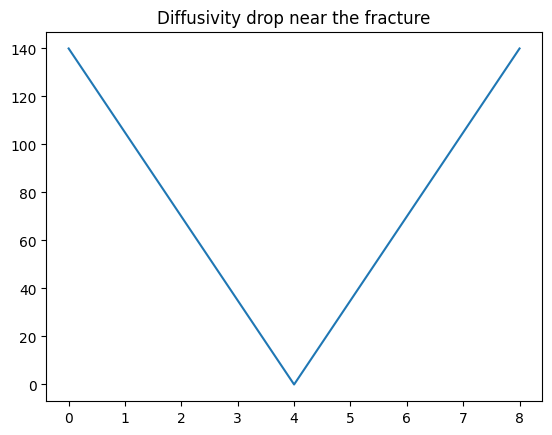

In [11]:
# Set up the diffusivity array
ratio = 0.000001
drop_array = np.linspace(1, ratio, 5)
drop_array_rev = drop_array[::-1][1:]
drop_array = np.concatenate([drop_array, drop_array_rev])
plt.figure()
plt.plot(drop_array * 140)
plt.title("Diffusivity drop near the fracture")
plt.show()

In [12]:
# Apply the diffusivity drop at frac hit
diffusivity_array = np.ones_like(mesh) * 140
for frac_hit_iter in frac_hit:
    idx, _ = mesh_utils.locate(mesh, frac_hit_iter)
    diffusivity_array[idx - 4: idx + 5] = drop_array * 140

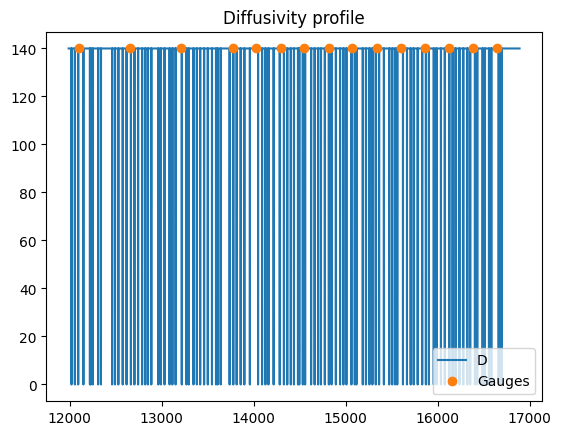

In [13]:
plt.figure()
plt.plot(mesh, diffusivity_array, label='D')
plt.plot(gauge_md, np.ones_like(gauge_md) * 140, 'o', label='Gauges')
plt.title("Diffusivity profile")
plt.legend()
plt.show()